In [14]:
from sklearn import datasets
from time import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# Importing our own
from models.trainer import TrainModelWrapper
from models.classification import Classification, Classification_Dropout
from models.regression import Regression, Regression_Dropout
import utils.datasets as DB

## Classification

In [15]:
datasets = DB.Datasets()
train_mnist, test_mnist = datasets.get_MNIST()
train_mnist, val_mnist = torch.utils.data.random_split(train_mnist, [50000, 10000])

In [16]:
# Multi Class Problem
class NeuralNetwork(nn.Module):
    
    def __init__(self,input_dim,hidden_nodes, num_classes, dropout=False):
        super(NeuralNetwork,self).__init__()
        
        self.input_dim = input_dim
        self.dropout = dropout
        self.linear1 = nn.Linear(input_dim,hidden_nodes)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(hidden_nodes,hidden_nodes)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(hidden_nodes,num_classes)
        if dropout:
            self.drop1 = nn.Dropout(0.2)
            self.drop2 = nn.Dropout(0.5)
            self.drop3 = nn.Dropout(0.5)
    
    def forward(self,x):
        x = x.view(-1, self.input_dim)
        if self.dropout:
            x = self.drop1(x)
        out = self.linear1(x)
        
        if self.dropout:
            out = self.drop2(out)
        out = self.relu1(out)
        out = self.linear2(out)
        
        if self.dropout:
            out = self.drop3(out)
        out = self.relu2(out)
        out = self.linear3(out)
        # NO SOFTMAX since done by crossentropyloss
        return out

In [111]:
def train_save_classification(nodes_hidden, learning_rate, name, dropout=False):
    num_epochs = 600
    batch_size = 128
    
    if not dropout:
        model = Classification(input_dim=784, output_dim=10, hl_units=nodes_hidden, hl_type=nn.Linear)
    else:
        model = Classification_Dropout(input_dim=784, output_dim=10, hl_units=nodes_hidden, hl_type=nn.Linear)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    
    args = {
            'model': model,
            'train_dataset': train_mnist,
            'criterion': criterion,
            'batch_size': batch_size,
            'optimizer': optimizer,
            'es_flag': False,
            'num_epochs': num_epochs,
            'val_dataset': val_mnist,
            'test_dataset': test_mnist,
            'mode': 2
            }
    trainer = TrainModelWrapper(**args)
    model, history = trainer.train()
    
    torch.save(model.state_dict(), 'weights/'+name+'.pth')
    return model, history
    

In [110]:
lrs = [1e-3, 1e-4, 1e-5]
layers = [400, 800, 1200]

for lr in lrs:
    for hidden_size in layers:
        _name = f"{hidden_size}_{lr:.0e}"
        print(_name)
        train_save_classification(nodes_hidden=hidden_size, learning_rate=lr, name=_name)
        
for lr in lrs:
    for hidden_size in layers:
        _name = f"drop_{hidden_size}_{lr:.0e}"
        print(_name)
        train_save_classification(nodes_hidden=hidden_size, learning_rate=lr, name=_name, dropout=True)


2023-02-24 10:55:50,522 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


drop_400_1e-03
The tensorboard model name corresponding to this model is chalky-stream
Epoch 1/10
----------


 71%|████████████████████████▊          | 277/391 [00:17<00:07, 16.23it/s]


KeyboardInterrupt: 

In [21]:
# Loading the model again and continuing training is possible
"""
new_model = MLPModel(input_dim=784, output_dim=10, hidden_layer=400)
new_model.load_state_dict(torch.load('weights/400_1e-03.pth'))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(new_model.parameters(),lr=1e-3)

args = {
        'model': new_model,
        'train_dataset': train_mnist,
        'criterion': criterion,
        'batch_size': 128,
        'optimizer': optimizer,
        'es_flag': False,
        'num_epochs': 10,
        'val_dataset': val_mnist,
        'mode': 2
        }
trainer = TrainModelWrapper(**args)
model, history = trainer.train()
"""

"\nnew_model = MLPModel(input_dim=784, output_dim=10, hidden_layer=400)\nnew_model.load_state_dict(torch.load('weights/400_1e-03.pth'))\n\ncriterion = nn.CrossEntropyLoss()\noptimizer = torch.optim.SGD(new_model.parameters(),lr=1e-3)\n\nargs = {\n        'model': new_model,\n        'train_dataset': train_mnist,\n        'criterion': criterion,\n        'batch_size': 128,\n        'optimizer': optimizer,\n        'es_flag': False,\n        'num_epochs': 10,\n        'val_dataset': val_mnist,\n        'mode': 2\n        }\ntrainer = TrainModelWrapper(**args)\nmodel, history = trainer.train()\n"

## Regression

In [62]:
datasets = DB.Datasets()
train_regr, test_regr = datasets.get_regression()

2023-02-24 10:22:21,710 [INFO] get_regression method called
2023-02-24 10:22:21,718 [INFO] Found the Files


C:\Users\vilde\AppData\Local\Temp/ipykernel_27576/1443985681.py:1: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  plt.scatter(x=np.array(train_regr)[:,0], y=np.array(train_regr)[:,1], color='r')
C:\Users\vilde\AppData\Local\Temp/ipykernel_27576/1443985681.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plt.scatter(x=np.array(train_regr)[:,0], y=np.array(train_reg

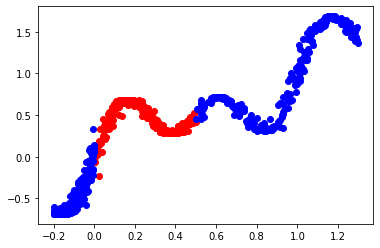

In [63]:
plt.scatter(x=np.array(train_regr)[:,0], y=np.array(train_regr)[:,1], color='r')
plt.scatter(x=np.array(test_regr)[:,0], y=np.array(test_regr)[:,1], color='b')

In [112]:
def train_save_regression(nodes_hidden, learning_rate, name, dropout=False):
    num_epochs = 600
    batch_size = 128
    
    if not dropout:
        model = Regression(input_dim=1, output_dim=1, hl_units=nodes_hidden, hl_type=nn.Linear)
    else:
        model = Regression_Dropout(input_dim=1, output_dim=1, hl_units=nodes_hidden, hl_type=nn.Linear)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    
    args = {
            'model': model,
            'train_dataset': train_regr,
            'criterion': criterion,
            'batch_size': batch_size,
            'optimizer': optimizer,
            'es_flag': False,
            'num_epochs': num_epochs,
            'val_dataset': test_regr,
            'test_dataset': None,
            'mode': 0
            }
    trainer = TrainModelWrapper(**args)
    model, history = trainer.train()
    
    torch.save(model.state_dict(), 'weights/'+name+'.pth')
    return model, history

In [108]:
lrs = [1e-3, 1e-4, 1e-5]
layers = [400, 800, 1200]

for lr in lrs:
    for hidden_size in layers:
        _name = f"regr_{hidden_size}_{lr:.0e}"
        print(_name)
        train_save_regression(nodes_hidden=hidden_size, learning_rate=lr, name=_name)
        
for lr in lrs:
    for hidden_size in layers:
        _name = f"regr_drop_{hidden_size}_{lr:.0e}"
        print(_name)
        m, h = train_save_regression(nodes_hidden=hidden_size, learning_rate=lr, name=_name, dropout=True)

2023-02-24 10:54:55,177 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


regr_400_1e-03
The tensorboard model name corresponding to this model is perpendicular-jersey
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 50.48it/s]


train Loss: 0.0489


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 68.37it/s]


val Loss: 0.1574

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 42.34it/s]


train Loss: 0.0489


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 94.28it/s]


val Loss: 0.1574

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 53.75it/s]


train Loss: 0.0489


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 104.25it/s]


val Loss: 0.1574

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 59.10it/s]


train Loss: 0.0446


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 100.00it/s]


val Loss: 0.1511

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 45.85it/s]


train Loss: 0.0391


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 89.20it/s]


val Loss: 0.1511

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 53.81it/s]


train Loss: 0.0391


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 103.70it/s]


val Loss: 0.1511

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 73.91it/s]


train Loss: 0.0391


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 120.73it/s]


val Loss: 0.1511

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 58.25it/s]


train Loss: 0.0358


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 109.66it/s]


val Loss: 0.1467

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 70.32it/s]


train Loss: 0.0317


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 96.12it/s]


val Loss: 0.1467

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 58.89it/s]


train Loss: 0.0317


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 126.32it/s]
2023-02-24 10:54:56,072 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


val Loss: 0.1467

Training completed in 0h 0m 1s
regr_800_1e-03
The tensorboard model name corresponding to this model is ivory-goose
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 18.66it/s]


train Loss: 0.0519


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 50.45it/s]


val Loss: 0.1683

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 30.52it/s]


train Loss: 0.0519


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 73.09it/s]


val Loss: 0.1683

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 24.61it/s]


train Loss: 0.0519


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 66.88it/s]


val Loss: 0.1683

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 28.15it/s]


train Loss: 0.0460


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 65.47it/s]


val Loss: 0.1583

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 29.91it/s]


train Loss: 0.0381


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 68.91it/s]


val Loss: 0.1583

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 33.93it/s]


train Loss: 0.0381


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 88.52it/s]


val Loss: 0.1583

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 30.50it/s]


train Loss: 0.0381


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 73.82it/s]


val Loss: 0.1583

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 34.76it/s]


train Loss: 0.0340


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 76.15it/s]


val Loss: 0.1521

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 31.21it/s]


train Loss: 0.0287


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 78.33it/s]


val Loss: 0.1521

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 35.66it/s]


train Loss: 0.0287


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 78.09it/s]


val Loss: 0.1521

Training completed in 0h 0m 1s


2023-02-24 10:54:57,530 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


regr_1200_1e-03
The tensorboard model name corresponding to this model is tractable-zoom
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 17.64it/s]


train Loss: 0.0757


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 36.54it/s]


val Loss: 0.1856

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 11.81it/s]


train Loss: 0.0757


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 39.90it/s]


val Loss: 0.1856

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 14.20it/s]


train Loss: 0.0757


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 51.68it/s]


val Loss: 0.1856

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 17.05it/s]


train Loss: 0.0608


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 49.95it/s]


val Loss: 0.1622

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 18.71it/s]


train Loss: 0.0430


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 52.71it/s]


val Loss: 0.1622

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 18.00it/s]


train Loss: 0.0430


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 47.97it/s]


val Loss: 0.1622

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 18.72it/s]


train Loss: 0.0430


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 54.82it/s]


val Loss: 0.1622

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 16.90it/s]


train Loss: 0.0353


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 47.75it/s]


val Loss: 0.1522

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.19it/s]


train Loss: 0.0261


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 49.21it/s]


val Loss: 0.1522

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 20.36it/s]


train Loss: 0.0261


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 51.61it/s]
2023-02-24 10:54:59,776 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


val Loss: 0.1522

Training completed in 0h 0m 2s
regr_400_1e-04
The tensorboard model name corresponding to this model is ragged-briefcase
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 75.18it/s]


train Loss: 0.0773


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 134.07it/s]


val Loss: 0.1960

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 60.27it/s]


train Loss: 0.0773


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 120.46it/s]


val Loss: 0.1960

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 66.81it/s]


train Loss: 0.0773


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 87.23it/s]


val Loss: 0.1960

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 59.99it/s]


train Loss: 0.0767


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 118.41it/s]


val Loss: 0.1947

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 88.29it/s]


train Loss: 0.0758


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 114.99it/s]


val Loss: 0.1947

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 64.15it/s]


train Loss: 0.0758


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 131.13it/s]


val Loss: 0.1947

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 59.98it/s]


train Loss: 0.0758


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 120.64it/s]


val Loss: 0.1947

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 63.60it/s]


train Loss: 0.0751


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 91.04it/s]


val Loss: 0.1934

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 59.60it/s]


train Loss: 0.0743


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 118.36it/s]


val Loss: 0.1934

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 78.25it/s]


train Loss: 0.0743


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 164.55it/s]
2023-02-24 10:55:00,578 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


val Loss: 0.1934

Training completed in 0h 0m 1s
regr_800_1e-04
The tensorboard model name corresponding to this model is prepared-bronze
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 30.25it/s]


train Loss: 0.0173


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 78.28it/s]


val Loss: 0.1668

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 29.85it/s]


train Loss: 0.0173


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 80.24it/s]


val Loss: 0.1668

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 38.87it/s]


train Loss: 0.0173


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 69.95it/s]


val Loss: 0.1668

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 34.47it/s]


train Loss: 0.0172


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 74.72it/s]


val Loss: 0.1666

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 30.79it/s]


train Loss: 0.0169


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 65.39it/s]


val Loss: 0.1666

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 32.51it/s]


train Loss: 0.0169


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 74.12it/s]


val Loss: 0.1666

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 32.28it/s]


train Loss: 0.0169


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 69.62it/s]


val Loss: 0.1666

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 33.55it/s]


train Loss: 0.0168


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 81.18it/s]


val Loss: 0.1664

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 31.19it/s]


train Loss: 0.0165


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 71.55it/s]


val Loss: 0.1664

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 35.71it/s]


train Loss: 0.0165


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 71.90it/s]


val Loss: 0.1664

Training completed in 0h 0m 1s


2023-02-24 10:55:01,921 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


regr_1200_1e-04
The tensorboard model name corresponding to this model is cyan-heron
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 16.97it/s]


train Loss: 0.0231


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 37.27it/s]


val Loss: 0.1467

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.55it/s]


train Loss: 0.0231


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 40.23it/s]


val Loss: 0.1467

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.52it/s]


train Loss: 0.0231


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 48.58it/s]


val Loss: 0.1467

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 13.74it/s]


train Loss: 0.0227


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 48.34it/s]


val Loss: 0.1464

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 17.25it/s]


train Loss: 0.0222


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 43.12it/s]


val Loss: 0.1464

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.22it/s]


train Loss: 0.0222


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 49.52it/s]


val Loss: 0.1464

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 14.54it/s]


train Loss: 0.0222


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 51.75it/s]


val Loss: 0.1464

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 17.75it/s]


train Loss: 0.0219


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 47.46it/s]


val Loss: 0.1462

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 16.72it/s]


train Loss: 0.0215


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 46.38it/s]


val Loss: 0.1462

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.15it/s]


train Loss: 0.0215


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 47.55it/s]
2023-02-24 10:55:04,300 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


val Loss: 0.1462

Training completed in 0h 0m 2s
regr_400_1e-05
The tensorboard model name corresponding to this model is quiet-knife
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 51.42it/s]


train Loss: 0.0717


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 123.72it/s]


val Loss: 0.1798

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 52.97it/s]


train Loss: 0.0717


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 127.47it/s]


val Loss: 0.1798

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 56.59it/s]


train Loss: 0.0717


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 94.80it/s]


val Loss: 0.1798

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 66.87it/s]


train Loss: 0.0717


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 96.29it/s]


val Loss: 0.1797

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 45.60it/s]


train Loss: 0.0716


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 118.33it/s]


val Loss: 0.1797

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 63.99it/s]


train Loss: 0.0716


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 123.08it/s]


val Loss: 0.1797

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 60.84it/s]


train Loss: 0.0716


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 91.13it/s]


val Loss: 0.1797

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 58.12it/s]


train Loss: 0.0716


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 91.24it/s]


val Loss: 0.1796

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 70.89it/s]


train Loss: 0.0715


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 81.13it/s]


val Loss: 0.1796

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 59.65it/s]


train Loss: 0.0715


100%|██████████████████████████████████████| 4/4 [00:00<00:00, 132.67it/s]
2023-02-24 10:55:05,174 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


val Loss: 0.1796

Training completed in 0h 0m 1s
regr_800_1e-05
The tensorboard model name corresponding to this model is oily-shed
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 30.66it/s]


train Loss: 0.1218


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 78.56it/s]


val Loss: 0.2251

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 28.57it/s]


train Loss: 0.1218


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 88.18it/s]


val Loss: 0.2251

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 31.47it/s]


train Loss: 0.1218


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 82.51it/s]


val Loss: 0.2251

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 27.70it/s]


train Loss: 0.1216


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 68.89it/s]


val Loss: 0.2247

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 26.86it/s]


train Loss: 0.1214


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 68.72it/s]


val Loss: 0.2247

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 29.19it/s]


train Loss: 0.1214


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 58.73it/s]


val Loss: 0.2247

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 21.61it/s]


train Loss: 0.1214


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 61.26it/s]


val Loss: 0.2247

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 30.60it/s]


train Loss: 0.1212


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 68.70it/s]


val Loss: 0.2244

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 30.70it/s]


train Loss: 0.1210


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 61.99it/s]


val Loss: 0.2244

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 33.84it/s]


train Loss: 0.1210


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 59.84it/s]

val Loss: 0.2244

Training completed in 0h 0m 1s



2023-02-24 10:55:06,660 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


regr_1200_1e-05
The tensorboard model name corresponding to this model is zesty-benefit
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.50it/s]


train Loss: 0.0282


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 48.44it/s]


val Loss: 0.1689

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 18.63it/s]


train Loss: 0.0282


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 47.50it/s]


val Loss: 0.1689

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 17.47it/s]


train Loss: 0.0282


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 48.58it/s]


val Loss: 0.1689

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 17.25it/s]


train Loss: 0.0282


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 50.69it/s]


val Loss: 0.1689

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 16.82it/s]


train Loss: 0.0281


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 40.02it/s]


val Loss: 0.1689

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 13.51it/s]


train Loss: 0.0281


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 39.58it/s]


val Loss: 0.1689

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 13.78it/s]


train Loss: 0.0281


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 42.06it/s]


val Loss: 0.1689

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 18.01it/s]


train Loss: 0.0281


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 52.64it/s]


val Loss: 0.1688

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 16.50it/s]


train Loss: 0.0280


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 46.06it/s]


val Loss: 0.1688

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 18.52it/s]


train Loss: 0.0280


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 54.72it/s]
2023-02-24 10:55:08,873 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


val Loss: 0.1688

Training completed in 0h 0m 2s
regr_drop_400_1e-03
The tensorboard model name corresponding to this model is cyclic-fugue
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 40.97it/s]


train Loss: 0.0746


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 71.75it/s]


val Loss: 0.1965

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 59.43it/s]


train Loss: 0.0695


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 73.90it/s]


val Loss: 0.1945

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 61.58it/s]


train Loss: 0.0692


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 68.97it/s]


val Loss: 0.1888

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 45.26it/s]


train Loss: 0.0704


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 82.56it/s]


val Loss: 0.1818

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 50.09it/s]


train Loss: 0.0637


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 82.41it/s]


val Loss: 0.1828

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 52.58it/s]


train Loss: 0.0608


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 95.33it/s]


val Loss: 0.1850

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 40.53it/s]


train Loss: 0.0610


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 83.83it/s]


val Loss: 0.1892

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 47.30it/s]


train Loss: 0.0570


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 77.96it/s]


val Loss: 0.1855

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 41.05it/s]


train Loss: 0.0525


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 80.34it/s]


val Loss: 0.1833

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 59.44it/s]


train Loss: 0.0489


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 95.36it/s]


val Loss: 0.1932

Training completed in 0h 0m 1s


2023-02-24 10:55:09,913 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


regr_drop_800_1e-03
The tensorboard model name corresponding to this model is espressivo-packet
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 29.83it/s]


train Loss: 0.0889


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 50.49it/s]


val Loss: 0.1869

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 28.37it/s]


train Loss: 0.0885


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 53.85it/s]


val Loss: 0.1902

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 25.89it/s]


train Loss: 0.0902


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 49.48it/s]


val Loss: 0.1853

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 25.55it/s]


train Loss: 0.0738


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 52.23it/s]


val Loss: 0.1698

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 30.68it/s]


train Loss: 0.0635


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 55.26it/s]


val Loss: 0.1639

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 32.53it/s]


train Loss: 0.0665


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 58.29it/s]


val Loss: 0.1693

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 27.08it/s]


train Loss: 0.0620


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 55.64it/s]


val Loss: 0.1606

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 24.46it/s]


train Loss: 0.0556


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 54.07it/s]


val Loss: 0.1594

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 24.65it/s]


train Loss: 0.0467


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 53.30it/s]


val Loss: 0.1544

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 26.78it/s]


train Loss: 0.0499


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 53.37it/s]
2023-02-24 10:55:11,553 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


val Loss: 0.1601

Training completed in 0h 0m 2s
regr_drop_1200_1e-03
The tensorboard model name corresponding to this model is succulent-levee
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.76it/s]


train Loss: 0.0945


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 36.10it/s]


val Loss: 0.2047

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.30it/s]


train Loss: 0.0935


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 33.15it/s]


val Loss: 0.2147

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.70it/s]


train Loss: 0.0935


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 35.84it/s]


val Loss: 0.2137

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.82it/s]


train Loss: 0.0778


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 32.72it/s]


val Loss: 0.1798

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 14.51it/s]


train Loss: 0.0526


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 34.82it/s]


val Loss: 0.1786

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.33it/s]


train Loss: 0.0546


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 31.50it/s]


val Loss: 0.1748

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 14.57it/s]


train Loss: 0.0540


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 33.37it/s]


val Loss: 0.1716

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 12.22it/s]


train Loss: 0.0433


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 28.46it/s]


val Loss: 0.1646

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 10.43it/s]


train Loss: 0.0347


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 29.56it/s]


val Loss: 0.1606

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 13.52it/s]


train Loss: 0.0328


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 29.36it/s]


val Loss: 0.1638

Training completed in 0h 0m 3s


2023-02-24 10:55:14,442 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


regr_drop_400_1e-04
The tensorboard model name corresponding to this model is mature-service
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 39.86it/s]


train Loss: 0.0769


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 75.80it/s]


val Loss: 0.2408

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 44.40it/s]


train Loss: 0.0810


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 86.67it/s]


val Loss: 0.2367

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 41.51it/s]


train Loss: 0.0794


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 75.63it/s]


val Loss: 0.2375

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 35.49it/s]


train Loss: 0.0842


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 63.68it/s]


val Loss: 0.2315

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 48.63it/s]


train Loss: 0.0788


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 75.50it/s]


val Loss: 0.2243

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 56.05it/s]


train Loss: 0.0782


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 97.04it/s]


val Loss: 0.2253

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 58.88it/s]


train Loss: 0.0854


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 81.21it/s]


val Loss: 0.2257

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 53.77it/s]


train Loss: 0.0802


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 84.66it/s]


val Loss: 0.2446

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 54.45it/s]


train Loss: 0.0734


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 84.30it/s]

val Loss: 0.2344



Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 45.85it/s]


train Loss: 0.0725


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 79.99it/s]
2023-02-24 10:55:15,486 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


val Loss: 0.2281

Training completed in 0h 0m 1s
regr_drop_800_1e-04
The tensorboard model name corresponding to this model is noisy-capitol
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 27.28it/s]


train Loss: 0.1190


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 48.65it/s]


val Loss: 0.2402

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 25.53it/s]


train Loss: 0.1208


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 47.78it/s]


val Loss: 0.2463

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 26.53it/s]


train Loss: 0.1192


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 43.46it/s]

val Loss: 0.2469

Epoch 4/10
----------



100%|███████████████████████████████████████| 2/2 [00:00<00:00, 22.74it/s]


train Loss: 0.1218


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 44.70it/s]


val Loss: 0.2352

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 21.91it/s]


train Loss: 0.1145


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 42.27it/s]


val Loss: 0.2338

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.40it/s]


train Loss: 0.1170


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 47.41it/s]


val Loss: 0.2312

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 23.13it/s]


train Loss: 0.1134


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 43.34it/s]


val Loss: 0.2364

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 25.00it/s]


train Loss: 0.1138


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 49.10it/s]


val Loss: 0.2335

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 22.27it/s]


train Loss: 0.1076


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 44.90it/s]


val Loss: 0.2320

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 22.37it/s]


train Loss: 0.1146


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 40.52it/s]
2023-02-24 10:55:17,502 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


val Loss: 0.2297

Training completed in 0h 0m 2s
regr_drop_1200_1e-04
The tensorboard model name corresponding to this model is bronze-coriander
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 14.66it/s]


train Loss: 0.0709


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 31.31it/s]


val Loss: 0.1982

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 14.21it/s]


train Loss: 0.0695


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 33.74it/s]


val Loss: 0.1957

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 13.11it/s]


train Loss: 0.0682


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 35.24it/s]


val Loss: 0.2001

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.21it/s]


train Loss: 0.0669


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 32.98it/s]


val Loss: 0.2039

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.11it/s]


train Loss: 0.0653


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 34.36it/s]


val Loss: 0.1875

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 13.19it/s]


train Loss: 0.0658


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 28.50it/s]


val Loss: 0.1914

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 14.25it/s]


train Loss: 0.0700


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 32.23it/s]


val Loss: 0.2001

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 14.17it/s]


train Loss: 0.0648


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 34.22it/s]


val Loss: 0.1930

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 13.83it/s]


train Loss: 0.0654


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 31.29it/s]


val Loss: 0.1936

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.56it/s]


train Loss: 0.0670


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 30.77it/s]
2023-02-24 10:55:20,279 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


val Loss: 0.1974

Training completed in 0h 0m 3s
regr_drop_400_1e-05
The tensorboard model name corresponding to this model is grating-column
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 46.71it/s]


train Loss: 0.0952


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 96.05it/s]


val Loss: 0.2298

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 48.20it/s]


train Loss: 0.1060


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 96.88it/s]


val Loss: 0.2351

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 48.74it/s]


train Loss: 0.1043


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 77.31it/s]


val Loss: 0.2270

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 44.94it/s]


train Loss: 0.1024


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 71.81it/s]


val Loss: 0.2336

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 51.48it/s]


train Loss: 0.1120


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 89.39it/s]


val Loss: 0.2291

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 44.32it/s]


train Loss: 0.1057


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 80.22it/s]


val Loss: 0.2354

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 55.65it/s]


train Loss: 0.1108


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 80.15it/s]


val Loss: 0.2254

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 45.67it/s]


train Loss: 0.1089


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 82.87it/s]


val Loss: 0.2366

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 47.81it/s]


train Loss: 0.1093


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 79.45it/s]


val Loss: 0.2362

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 49.21it/s]


train Loss: 0.1037


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 86.05it/s]
2023-02-24 10:55:21,287 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


val Loss: 0.2306

Training completed in 0h 0m 1s
regr_drop_800_1e-05
The tensorboard model name corresponding to this model is wicker-syntax
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 29.41it/s]


train Loss: 0.1294


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 49.05it/s]


val Loss: 0.2529

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 26.89it/s]


train Loss: 0.1290


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 48.80it/s]


val Loss: 0.2474

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 20.11it/s]


train Loss: 0.1268


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 42.68it/s]


val Loss: 0.2579

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 24.85it/s]


train Loss: 0.1281


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 61.35it/s]


val Loss: 0.2571

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 27.92it/s]


train Loss: 0.1270


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 50.29it/s]


val Loss: 0.2484

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 29.29it/s]


train Loss: 0.1251


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 54.58it/s]


val Loss: 0.2680

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 25.63it/s]


train Loss: 0.1290


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 54.30it/s]


val Loss: 0.2537

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 27.70it/s]


train Loss: 0.1247


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 47.26it/s]


val Loss: 0.2607

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 25.02it/s]


train Loss: 0.1305


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 51.18it/s]


val Loss: 0.2527

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 26.55it/s]


train Loss: 0.1217


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 49.52it/s]
2023-02-24 10:55:23,018 [WARNING] Scheduler Object not found amongst the Arguments. Ignore warning if scheduler wasn't meant to be in the loop


val Loss: 0.2532

Training completed in 0h 0m 2s
regr_drop_1200_1e-05
The tensorboard model name corresponding to this model is daring-snare
Epoch 1/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 17.49it/s]


train Loss: 0.0551


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 30.43it/s]


val Loss: 0.1767

Epoch 2/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.69it/s]


train Loss: 0.0552


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 34.27it/s]


val Loss: 0.1845

Epoch 3/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.99it/s]


train Loss: 0.0568


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 34.52it/s]


val Loss: 0.1878

Epoch 4/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 14.32it/s]


train Loss: 0.0575


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 36.59it/s]


val Loss: 0.1822

Epoch 5/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 14.97it/s]


train Loss: 0.0539


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 36.80it/s]


val Loss: 0.1812

Epoch 6/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.26it/s]


train Loss: 0.0569


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 28.67it/s]


val Loss: 0.1896

Epoch 7/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 18.03it/s]


train Loss: 0.0558


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 31.59it/s]


val Loss: 0.1836

Epoch 8/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.49it/s]


train Loss: 0.0534


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 43.50it/s]


val Loss: 0.1834

Epoch 9/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 14.97it/s]


train Loss: 0.0571


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 35.37it/s]


val Loss: 0.1829

Epoch 10/10
----------


100%|███████████████████████████████████████| 2/2 [00:00<00:00, 15.14it/s]


train Loss: 0.0613


100%|███████████████████████████████████████| 4/4 [00:00<00:00, 40.63it/s]

val Loss: 0.1810

Training completed in 0h 0m 3s
